# Resolving the Singularity in 2D

## 1. Setup / Rewrite functions for mpmath

In [59]:
from mpmath import mp, mpf, acos, cos, pi, quad, sqrt, findroot, fabs, linspace, fdiv, fadd, fmul, fsub, im, re, power, fneg
import matplotlib.pyplot as plt

t = 1
d = 2

mp.dps = 25

def heaviside(x):
    x = mpf(x)

    if x < 0:
        return 0
    else:
        return 1
    
def I_1(x):
    x = mpf(x)
    if fabs(x) <= 2 * t:
        result = heaviside(x + 2 * t) - (1 / pi) * acos(x / (2 * t))
    else:
        result = heaviside(x + 2 * t)
    return result

def I_2(x):
    x = mpf(x)
    
    def I_1_shifted(k):
        return I_1(x + 2 * t * cos(k))
    
    # Use mpmath's quad for integration
    integral_value = quad(I_1_shifted, [-pi, pi])
    
    return integral_value / (2 * pi)

def rho_hk_2d(mu, U):
    mu = mpf(mu)
    U = mpf(U)
    if U >= 0:
        return I_2(mu) + I_2(mu - U)
    else:
        return 2 * I_2(mu - U / 2)
    


def find_mu_of_rho_landau(rho, U, f_0):
    rho = mpf(rho)
    U = mpf(U)
    f_0 = mpf(f_0)

    lower = -2 * t * d
    upper = U + 2 * t * d + 2 * f_0
    bracket = (lower, upper)

    def func_mu(mu):
        return rho_hk_2d(mu - f_0 * rho, U) - rho

    try:
        mu_root = findroot(func_mu, bracket, solver='bisect', verbose=False, tol=mpf('1e-24'))
        return mu_root
    except Exception:
        raise RuntimeError(f"Keine Nullstelle gefunden für rho={rho}")
    
def create_mu_list(rho_array, U, f_0):
    mu_values = []
    N = len(rho_array)
    i = 1
    for rho_i in rho_array:
        print(f'\rProgress: {i / N * 100:.1f}%{' ' * 20}', end="", flush=True)
        i += 1
        try:
            mu = find_mu_of_rho_landau(rho_i, U, f_0)
            mu_values.append(mu)
        except RuntimeError:
            mu_values.append(mp.nan)
            print(f"Keine Nullstelle gefunden für rho={rho_i}")
    return mu_values


    
def DOS_HK_2D(E):
    E = mpf(E)

    def integrand_DOS_2d(k):
        arg = fadd(fdiv(E, 2 * t), cos(k))
        if -1 < arg < 1:
            return fdiv(1, sqrt(fsub(1, power(arg, 2))))
        else:
            return mpf(0)
        
    # These are the two potential singularities of the integrand
    # For any E, only one of them will ever be well defined (im(pot_sing_i) == 0)
    pot_singularity_1 = acos(fsub(1, fdiv(E, 2*t)))
    pot_singularity_2 = acos(fneg(fadd(1, fdiv(E, 2*t))))

    if im(pot_singularity_1) == 0:
        int_value = quad(integrand_DOS_2d, [0, re(pot_singularity_1), pi])
        #print(f'{E}: IF   result: {int_value}')
        full_DOS = int_value / (2 * pi**2 * t)
        return full_DOS
    elif im(pot_singularity_2) == 0:
        int_value = quad(integrand_DOS_2d, [0, re(pot_singularity_2), pi])
        #print(f'{E}: IF   result: {int_value}')
        full_DOS = int_value / (2 * pi**2 * t)
        return full_DOS
    else:
        int_value = quad(integrand_DOS_2d, [0, pi])
        #print(f'{E}: ELSE result: {int_value}')
        full_DOS = int_value / (2 * pi**2 * t)
        return full_DOS

def kappa_hk_2d(mu, U):
    mu = mpf(mu)
    U = mpf(U)
    if U >= 0:
        return fdiv(fadd(DOS_HK_2D(mu), DOS_HK_2D(fsub(mu, U))), 2)
    else:
        return DOS_HK_2D(mu - U / 2)

def kappa_landau_2d(rho, mu, U, f_0):
    rho = mpf(rho)
    mu = mpf(mu)
    U = mpf(U)
    f_0 = mpf(f_0)

    kappa_hk_renorm = kappa_hk_2d(fsub(mu, fmul(f_0, rho)), U)
    denominator = fadd(1, fmul(f_0, kappa_hk_renorm))

    if denominator == 0:
        return mpf('inf')  # or raise an exception
    
    return fdiv(kappa_hk_renorm, denominator)

def create_kappa_list_hk(mu_array, U):
    kappa_list = []

    for mu_val in mu_array:
        kappa_i = kappa_hk_2d(mu_val, U)
        kappa_list.append(kappa_i)

    return kappa_list

def create_kappa_list_landau(rho_array, mu_array, U, f_0):
    kappa_list = []

    for rho_val, mu_val in zip(rho_array, mu_array):
        try:
            kappa_i = kappa_landau_2d(rho_val, mu_val, U, f_0)
            kappa_list.append(kappa_i)
        except Exception:
            kappa_list.append(mp.nan)

    return kappa_list

def plot_mpf_arrays(x_array, y_array, xlabel='x', ylabel='y', title='Plot'):
    # Convert mpf elements to regular Python floats for plotting
    x_vals = [float(x) for x in x_array]
    y_vals = [float(y) if y is not None else float('nan') for y in y_array]

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, y_vals, lw=1.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 2. Test for HK Model

## Chemical Potential

In [3]:
rho_list = linspace(0, 2, 300)

mu_list_hk = create_mu_list(rho_list, 14, 0)

Progress: 100.0%                    Keine Nullstelle gefunden für rho=2.0


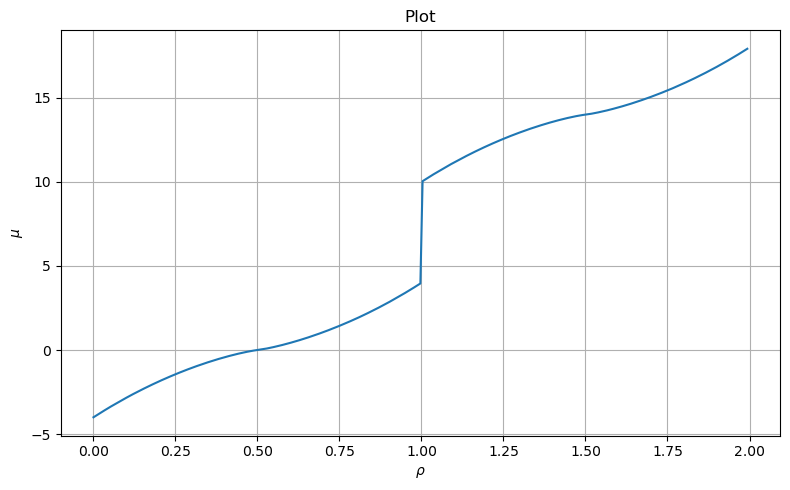

In [4]:

plot_mpf_arrays(rho_list, mu_list_hk, r'$\rho$', r'$\mu$')

## Compressibility

-4.0: IF   result: 0.0
-18.0: ELSE result: 0.0
-3.91675396965018: IF   result: 1.58735739622238
-17.9167539696502: ELSE result: 0.0
-3.83342973357185: IF   result: 1.60437916917209
-17.8334297335719: ELSE result: 0.0
-3.75228821780846: IF   result: 1.6214025741443
-17.7522882178085: ELSE result: 0.0
-3.67157974909424: IF   result: 1.638793382903
-17.6715797490942: ELSE result: 0.0
-3.59085373076349: IF   result: 1.65666642188393
-17.5908537307635: ELSE result: 0.0
-3.51066924649024: IF   result: 1.67491567385912
-17.5106692464902: ELSE result: 0.0
-3.43388762004257: IF   result: 1.69287590191127
-17.4338876200426: ELSE result: 0.0
-3.35432848206179: IF   result: 1.71201100485226
-17.3543284820618: ELSE result: 0.0
-3.27957195803701: IF   result: 1.73050156631457
-17.279571958037: ELSE result: 0.0
-3.20316293788667: IF   result: 1.74993719316403
-17.2031629378867: ELSE result: 0.0
-3.12644714413713: IF   result: 1.77002339191913
-17.1264471441371: ELSE result: 0.0
-3.05408156413602: IF 

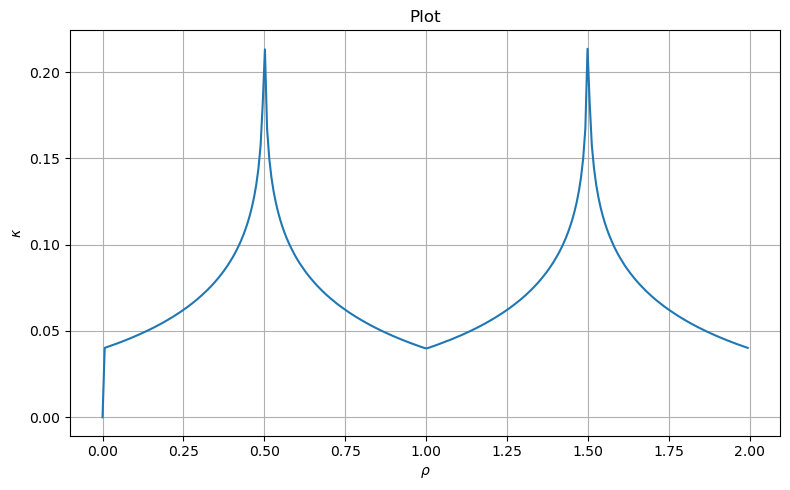

In [52]:
kappa_f0 = create_kappa_list_hk(mu_list_hk, 14)

plot_mpf_arrays(rho_list, kappa_f0, r'$\rho$', r'$\kappa$')

# 3. Test for HKL Model

Progress: 100.0%                    Keine Nullstelle gefunden für rho=2.0


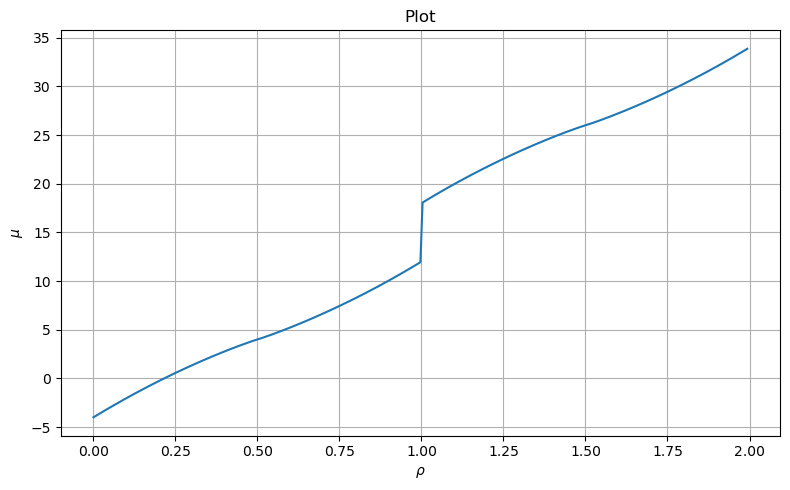

In [53]:
mu_list_hkl = create_mu_list(rho_list, 14, 8)
plot_mpf_arrays(rho_list, mu_list_hkl, r'$\rho$', r'$\mu$')

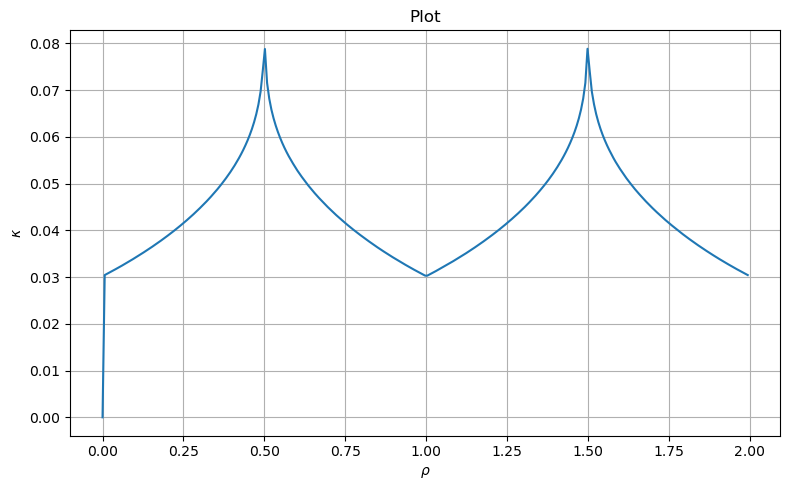

In [57]:
kappa_f8 = create_kappa_list_landau(rho_list, mu_list_hkl, 14, 8)
plot_mpf_arrays(rho_list, kappa_f8, r'$\rho$', r'$\kappa$')

# 4. Resolving The Singularity

In [60]:
rho_list_log = [mpf(1e-1),mpf(1e-2),mpf(1e-3),mpf(1e-4),mpf(1e-5),mpf(1e-6),mpf(1e-7),mpf(1e-8),mpf(1e-9),mpf(1e-10),
                mpf(1e-11),mpf(1e-12),mpf(1e-13),mpf(1e-14),mpf(1e-15),mpf(1e-16),mpf(1e-17),mpf(1e-18),mpf(1e-19),
                mpf(1e-20),mpf(1e-21),mpf(1e-22),mpf(1e-23)]

mu_list_log_f0 = create_mu_list(rho_list_log, 14, 0)
mu_list_log_f8 = create_mu_list(rho_list_log, 14, 8)

Progress: 100.0%                    

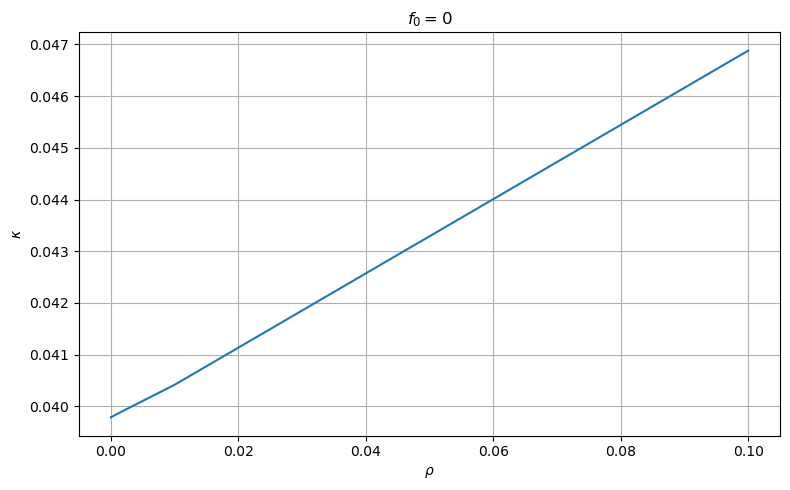

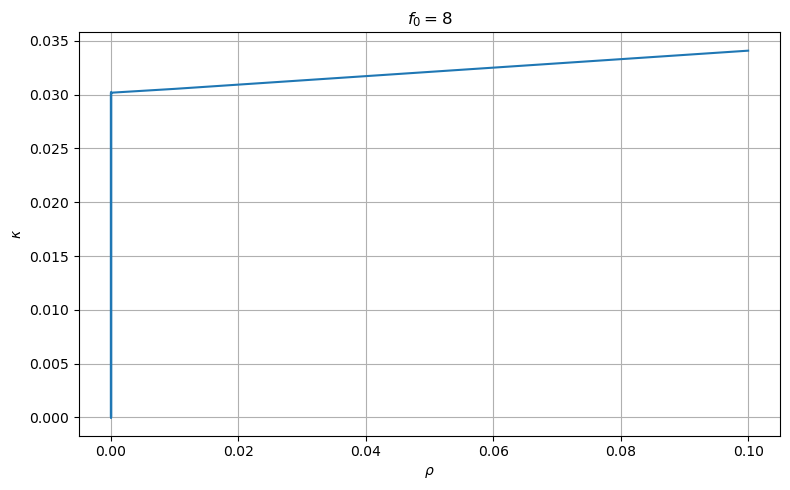

In [62]:
kappa_log_f0 = create_kappa_list_hk(mu_list_log_f0, 14)
kappa_log_f8 = create_kappa_list_landau(rho_list_log, mu_list_log_f8, 14, 8)

plot_mpf_arrays(rho_list_log, kappa_log_f0, r'$\rho$', r'$\kappa$', r'$f_0 = 0$')
plot_mpf_arrays(rho_list_log, kappa_log_f8, r'$\rho$', r'$\kappa$', r'$f_0 = 8$')